This analyzes the selig scMPRA transcriptome data, producing a list of valid cells and their cell-types.

In [26]:
import scanpy as sc
import h5py
import scipy.sparse as sp
from anndata import AnnData

In [2]:
data_root="/home/mcn26/palmer_scratch/tabula_data"

In [6]:
#This does not work: seelig is using a nonstandard format
#adata=sc.read_h5ad(f"{data_root}/GSM8305417_R1-scMPRA_tx.h5")

In [9]:
example = sc.datasets.pbmc3k()  
example.write(f"{data_root}/pbmc3k.h5ad")

In [12]:
tx=h5py.File(f"{data_root}/GSM8305417_R1-scMPRA_tx.h5",'r')
pbmc=h5py.File(f"{data_root}/pbmc3k.h5ad")

In [11]:
print(tx.keys())

<KeysViewHDF5 ['unknown']>


In [21]:
tx['unknown'].keys()

<KeysViewHDF5 ['barcodes', 'data', 'gene_names', 'genes', 'indices', 'indptr', 'shape']>

In [22]:
tx['unknown']['shape']

<HDF5 dataset "shape": shape (2,), type "<i4">

In [108]:
#Using `csc_matrix((data, indices, indptr), [shape=(M, N)])` invocation. 
X=sp.csc_matrix(
    (tx['unknown']['data'][:],tx['unknown']['indices'][:],tx['unknown']['indptr'][:]),
    tx['unknown']['shape'][:]
)

In [109]:
tx_adata=AnnData(X=X.tocsr().transpose(),
    obs=tx["unknown"]["barcodes"][:].astype(str),
    var=tx["unknown"]["genes"][:].astype(str)
    )

In [110]:
#rename the only column (which is full of ensembl gene IDs) to 
#`gene_id` and make it the index
tx_adata.var.rename({0:'gene_id'},axis=1,inplace=True)
tx_adata.var.index=tx_adata.var['gene_id']

#add gene names
tx_adata.var["gene_name"]=tx["unknown"]["gene_names"][:].astype(str)


In [111]:
tx_adata.var

,gene_id,gene_name
gene_id,,
ENSG00000290825.1,ENSG00000290825.1,DDX11L2
ENSG00000223972.6,ENSG00000223972.6,DDX11L1
ENSG00000227232.5,ENSG00000227232.5,WASH7P
ENSG00000278267.1,ENSG00000278267.1,MIR6859-1
ENSG00000243485.5,ENSG00000243485.5,MIR1302-2HG
...,...,...
ENSG00000198695.2,ENSG00000198695.2,MT-ND6
ENSG00000210194.1,ENSG00000210194.1,MT-TE
ENSG00000198727.2,ENSG00000198727.2,MT-CYB


Spot-checked a few & they look OK.

In [112]:
tx_adata.obs.rename({0:'barcode'},inplace=True,axis=1)
tx_adata.obs.index=tx_adata.obs['barcode']

In [113]:
tx_adata.obs

,barcode
barcode,
A9_A2_A2,A9_A2_A2
A6_A2_A2,A6_A2_A2
A2_B1_A2,A2_B1_A2
A5_B2_A2,A5_B2_A2
A1_B2_A2,A1_B2_A2
...,...
A7_F6_F8,A7_F6_F8
A12_F7_F8,A12_F7_F8
A5_F7_F8,A5_F7_F8


In [114]:
tx_adata_backup=tx_adata.copy()
tx_adata

/home/mcn26/.conda/envs/biopython/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 10640 × 62700
    obs: 'barcode'
    var: 'gene_id', 'gene_name'

Strange that there are duplicates..?

In [115]:
print(len(tx_adata.obs.index)==len(tx_adata.obs.index.unique()))
print(len(tx_adata.var.index)==len(tx_adata.var.index.unique()))

True
False


Ok, consulting the docs, this seems pretty normal when using `gene_id` to index the features. Probably multiple transcripts of the same gene are getting different entries.

In [116]:
tx_adata.var_names_make_unique()

In [117]:
print(len(tx_adata.var.index)==len(tx_adata.var.index.unique()))

True


> We filtered the cells based on a knee plot of per-cell transcriptome UMI counts. For the transcriptome data used for clustering and pseudobulk binning, we use normalized expression matrix following SCTransform scaling as implemented in Seurat.


The methods are light on details and there is no publsihed code, so let's just follow the [standard scanpy tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html).

In [118]:
tx_adata.var["mt"] = tx_adata.var["gene_name"].str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    tx_adata, qc_vars=["mt"], inplace=True, log1p=True
)

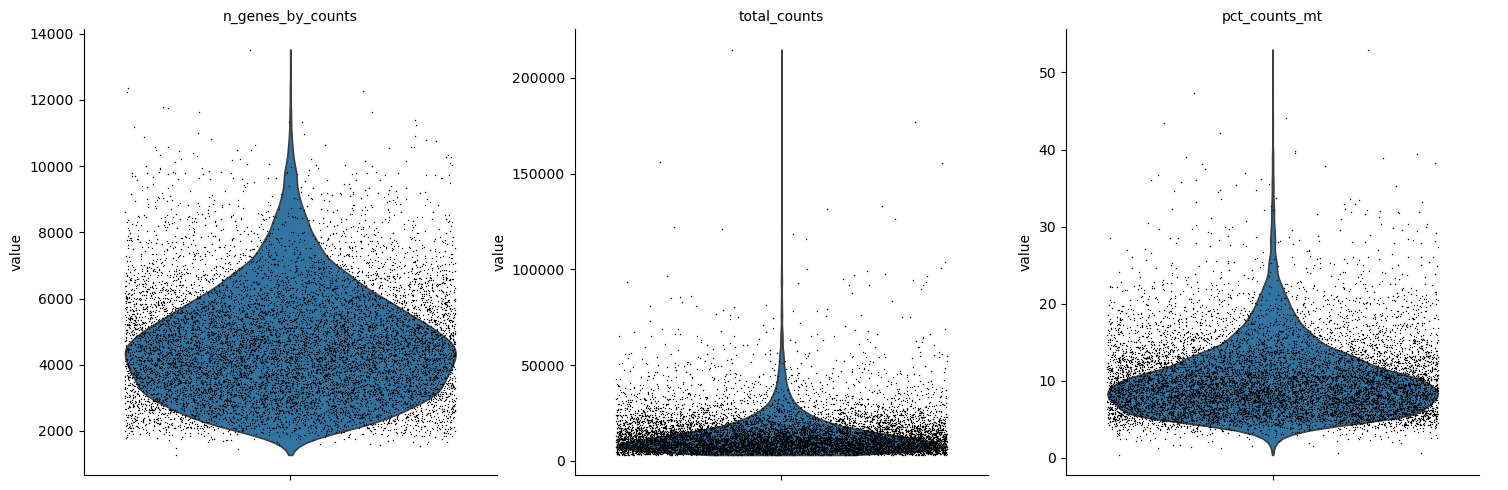

In [119]:
sc.pl.violin(
    tx_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

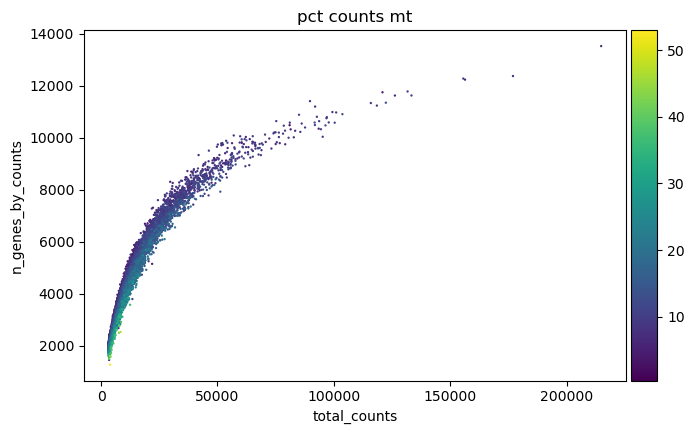

In [120]:
sc.pl.scatter(tx_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [121]:
#being super permissive
sc.pp.filter_cells(tx_adata, min_genes=100)
sc.pp.filter_genes(tx_adata, min_cells=3)

In [123]:
#kill doublets
sc.pp.scrublet(tx_adata)

In [125]:
tx_adata.layers["counts"] = tx_adata.X.copy()

In [126]:
# Normalizing to median total counts
sc.pp.normalize_total(tx_adata)
# Logarithmize the data
sc.pp.log1p(tx_adata)

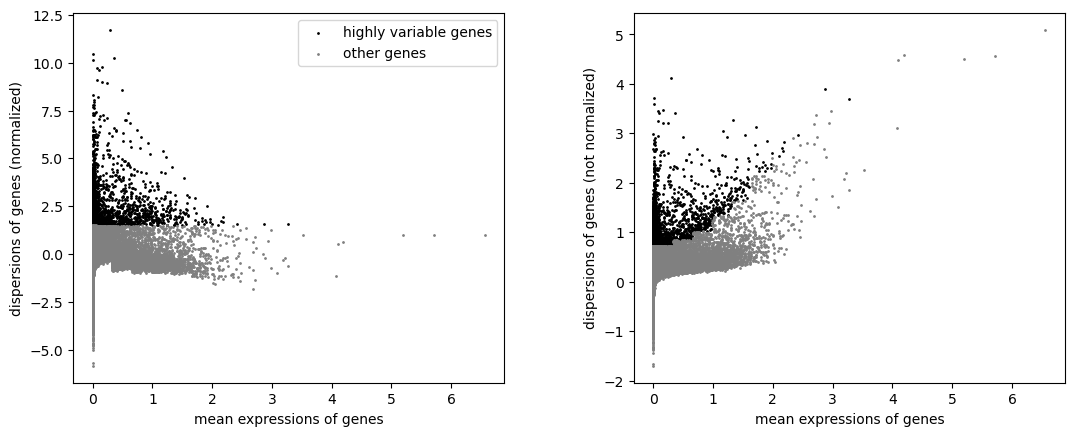

In [127]:
sc.pp.highly_variable_genes(tx_adata, n_top_genes=2000)
sc.pl.highly_variable_genes(tx_adata)

In [128]:
sc.tl.pca(tx_adata)

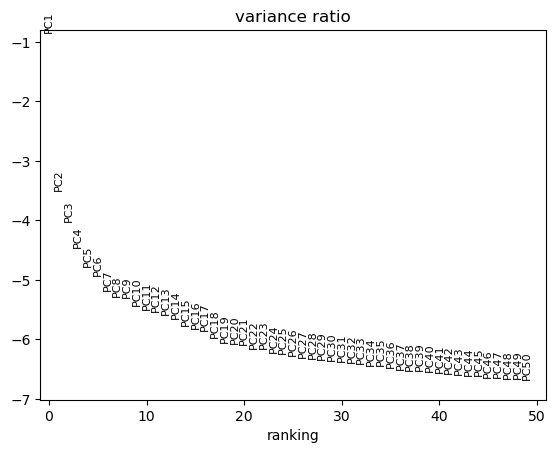

In [129]:
sc.pl.pca_variance_ratio(tx_adata, n_pcs=50, log=True)

I choose 17 PCs

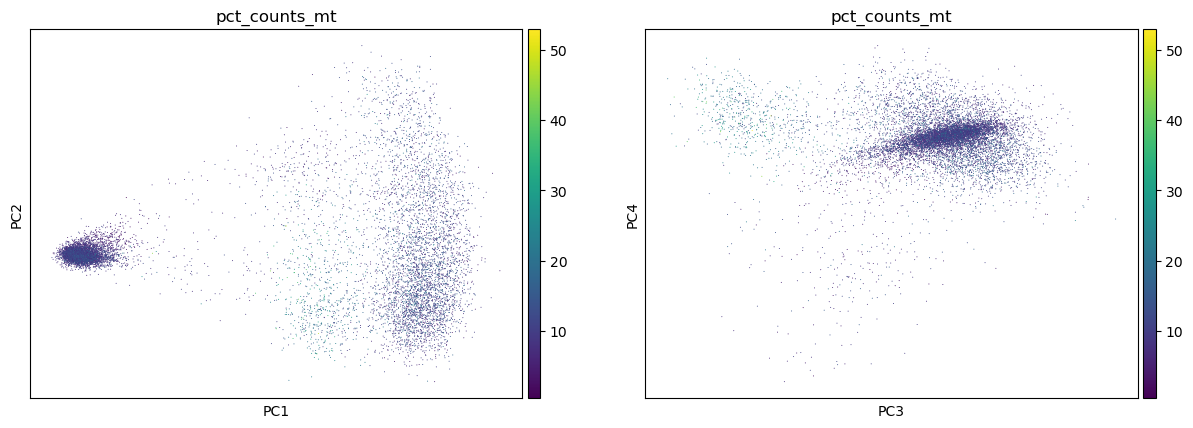

In [131]:
sc.pl.pca(
    tx_adata,
    color=["pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
)

Interesting... Not obvious that I can regress out one of the PCs. Let's try clustering & see if there is a cluster I can kill there. 

In [132]:
sc.pp.neighbors(tx_adata)

In [133]:
sc.tl.umap(tx_adata)

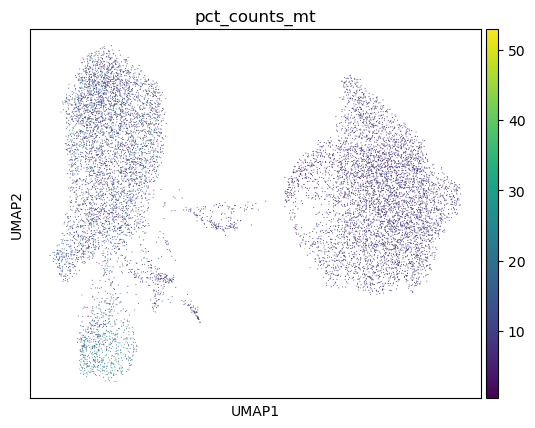

In [134]:
sc.pl.umap(
    tx_adata,
    color="pct_counts_mt",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

That blob at the bottom left looks like junk...

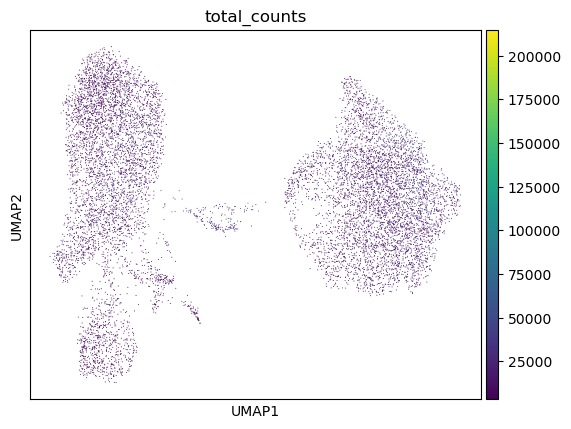

In [135]:
sc.pl.umap(
    tx_adata,
    color="total_counts",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

I thought that cluster in the middle might be doublets (k562+hepg2) but the counts aren't systemically higher...

In [138]:
sc.tl.leiden(tx_adata, flavor="igraph", n_iterations=2)

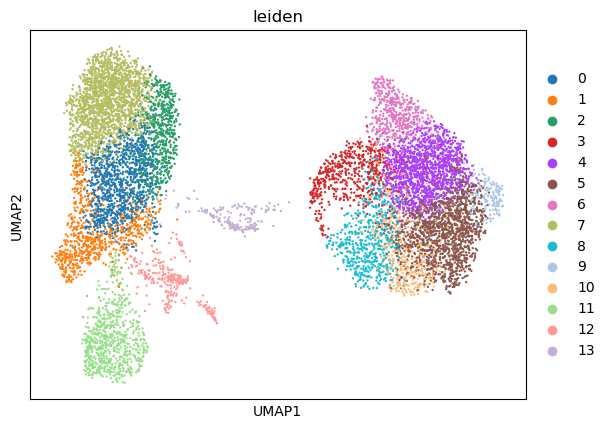

In [139]:
sc.pl.umap(tx_adata, color=["leiden"])

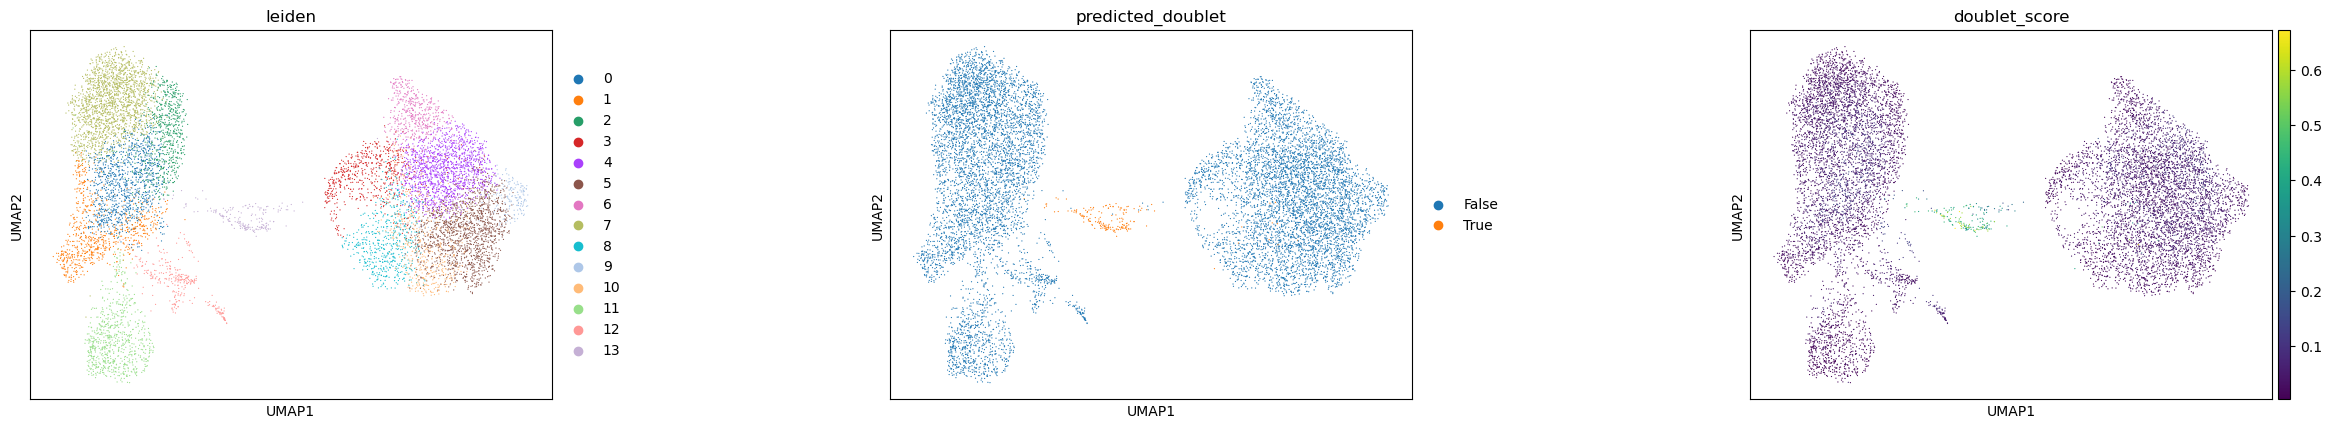

In [140]:
sc.pl.umap(
    tx_adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

cluster 13 is doublets.

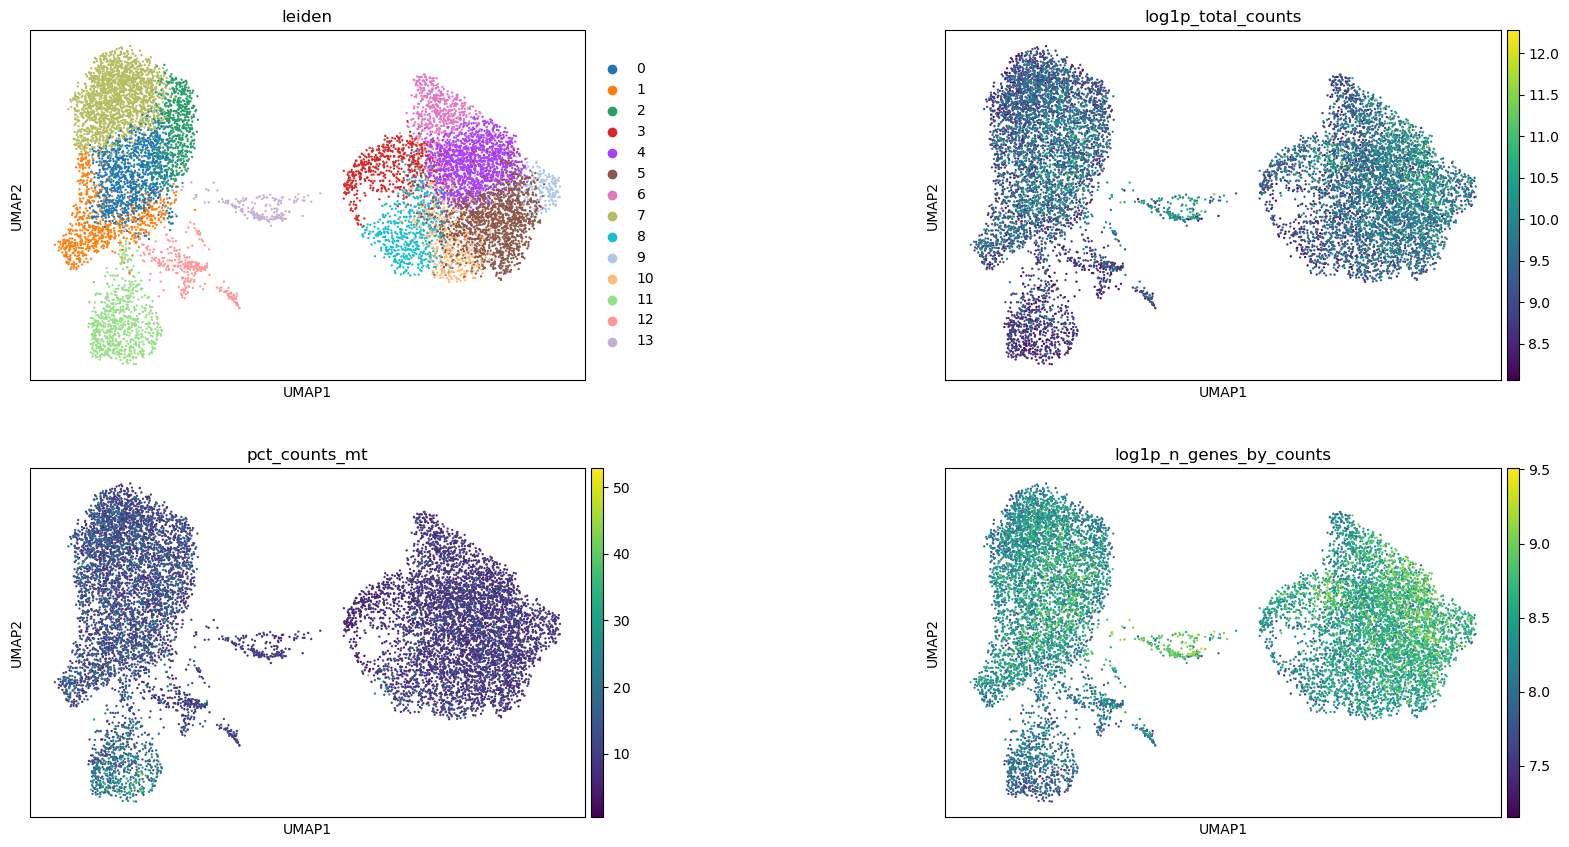

In [142]:
sc.pl.umap(
    tx_adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

cluster 11 is mito crap

In [146]:
tx_adata.var.index=tx_adata.var["gene_name"]

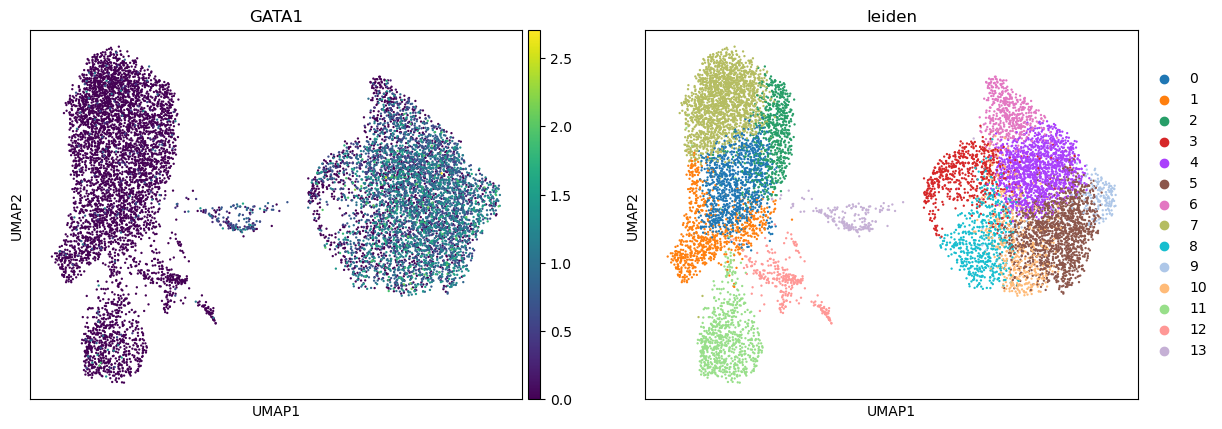

In [149]:
markers=["GATA1"]
sc.pl.umap(
    tx_adata,
    color=[*markers, "leiden"],
    ncols=3,
)

In [150]:
tx_adata = tx_adata[~tx_adata.obs["leiden"].isin(["11","13"])].copy()

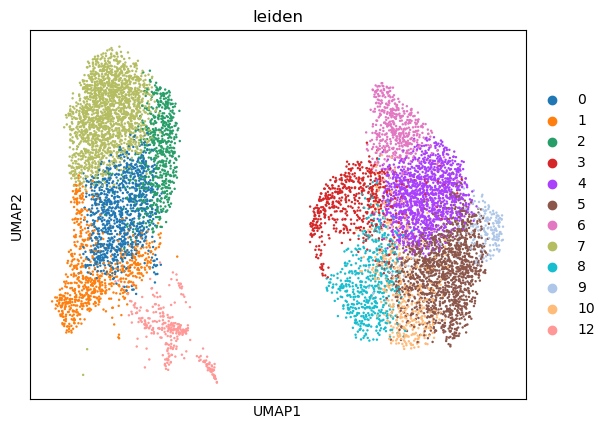

In [151]:
sc.pl.umap(
    tx_adata,
    color=["leiden"],
)

In [156]:
hepg2_clusters=["0","1","2","7","12"]
k562_clusters=["3","4","5","6","8","9","10"]

cluster_to_celltype={i:"K562" for i in k562_clusters} | {i:"HEPG2" for i in hepg2_clusters}

tx_adata.obs["cell_type"] = tx_adata.obs["leiden"].map(cluster_to_celltype)


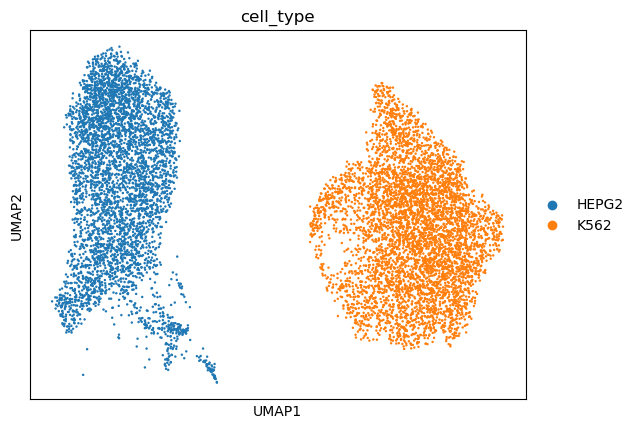

In [157]:
sc.pl.umap(
    tx_adata,
    color=["cell_type"],
)

In [158]:
tx_adata.write("filtered_seelig_tx.h5ad",compression="gzip")

In [164]:
tx_adata.obs[["cell_type"]].to_csv("acceptible_cells_and_cell_type.tsv",sep="\t")